In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine # Changed to load_wine
from scipy.stats import skew, kurtosis, shapiro, normaltest


In [2]:
# --- Step 1: Data Inspection and Understanding (Revised with load_wine) ---

print("--- Step 1: Data Inspection and Understanding ---")

# Comments: When to use ICA and its data requirements:
# ICA is suitable when you suspect that your observed data is a linear mixture of underlying,
# statistically independent, and non-Gaussian source signals.
# It's commonly used in signal processing (e.g., separating speech from noise, brain signal analysis like EEG/fMRI),
# image processing, and financial data analysis.
# Key requirements for the data:
# 1. Independence: The underlying source signals must be statistically independent of each other.
# 2. Non-Gaussianity: At most one of the independent components can be Gaussian. ICA relies on the
#    deviation from Gaussianity to find the independent components.
# 3. Linear Mixing: The observed signals must be a linear combination of the independent sources.
# 4. Number of Components: The number of observed signals should be at least equal to the number of
#    independent sources you wish to extract.



--- Step 1: Data Inspection and Understanding ---


In [3]:
# Load a relevant sample dataset from scikit-learn
# We'll use the Wine dataset, which contains chemical analysis of wines.
# The various chemical constituents can be seen as mixtures influenced by underlying
# independent factors like grape variety, soil, or fermentation processes.
wine = load_wine()
X = wine.data # Chemical features of the wines
y = wine.target # Wine class (cultivar) - we'll focus on X for ICA

# Create a pandas DataFrame for easier manipulation and inspection
# The feature_names attribute gives us descriptive column names.
df = pd.DataFrame(X, columns=wine.feature_names)

print("\n1.1. Dataset Overview (First 5 rows):")
print(df.head())
# Interpretation: This gives a quick look at the structure of the data: column names and the first
# few entries. We can see the different chemical measurements like 'alcohol', 'malic_acid', etc.




1.1. Dataset Overview (First 5 rows):
   alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0    14.23        1.71  2.43               15.6      127.0           2.80   
1    13.20        1.78  2.14               11.2      100.0           2.65   
2    13.16        2.36  2.67               18.6      101.0           2.80   
3    14.37        1.95  2.50               16.8      113.0           3.85   
4    13.24        2.59  2.87               21.0      118.0           2.80   

   flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0        3.06                  0.28             2.29             5.64  1.04   
1        2.76                  0.26             1.28             4.38  1.05   
2        3.24                  0.30             2.81             5.68  1.03   
3        3.49                  0.24             2.18             7.80  0.86   
4        2.69                  0.39             1.82             4.32  1.04   

   od280/od315_of_dilut

In [4]:
print("\n1.2. Dataset Information:")
df.info()
# Interpretation: `df.info()` provides a summary of the DataFrame, including the number of entries,
# columns, non-null values, and data types. This helps identify missing values (if any) and
# confirm data types. Here, we see 178 entries, 13 features, and all are non-null numerical values.




1.2. Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non

In [5]:
print("\n1.3. Descriptive Statistics:")
print(df.describe())
# Interpretation: `df.describe()` shows basic statistical measures for each numerical column:
# count, mean, standard deviation, min, max, and quartiles. This helps in understanding the
# central tendency, spread, and range of each feature. Notice the varying scales of different
# features (e.g., 'alcohol' values are around 13, while 'proline' values are in the hundreds).
# This difference in scale suggests that scaling might be beneficial later, although ICA itself
# is theoretically scale-invariant if internal whitening is performed.




1.3. Descriptive Statistics:
          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  178.000000  178.000000  178.000000         178.000000  178.000000   
mean    13.000618    2.336348    2.366517          19.494944   99.741573   
std      0.811827    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.362500    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.677500    3.082500    2.557500          21.500000  107.000000   
max     14.830000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            178.000000       178.000000   
mean        2.295112    2.029270              0.361854         1.590899   
std         0.625851    0.998859              0.124453      


1.4. Visualizing Feature Distributions (Histograms):


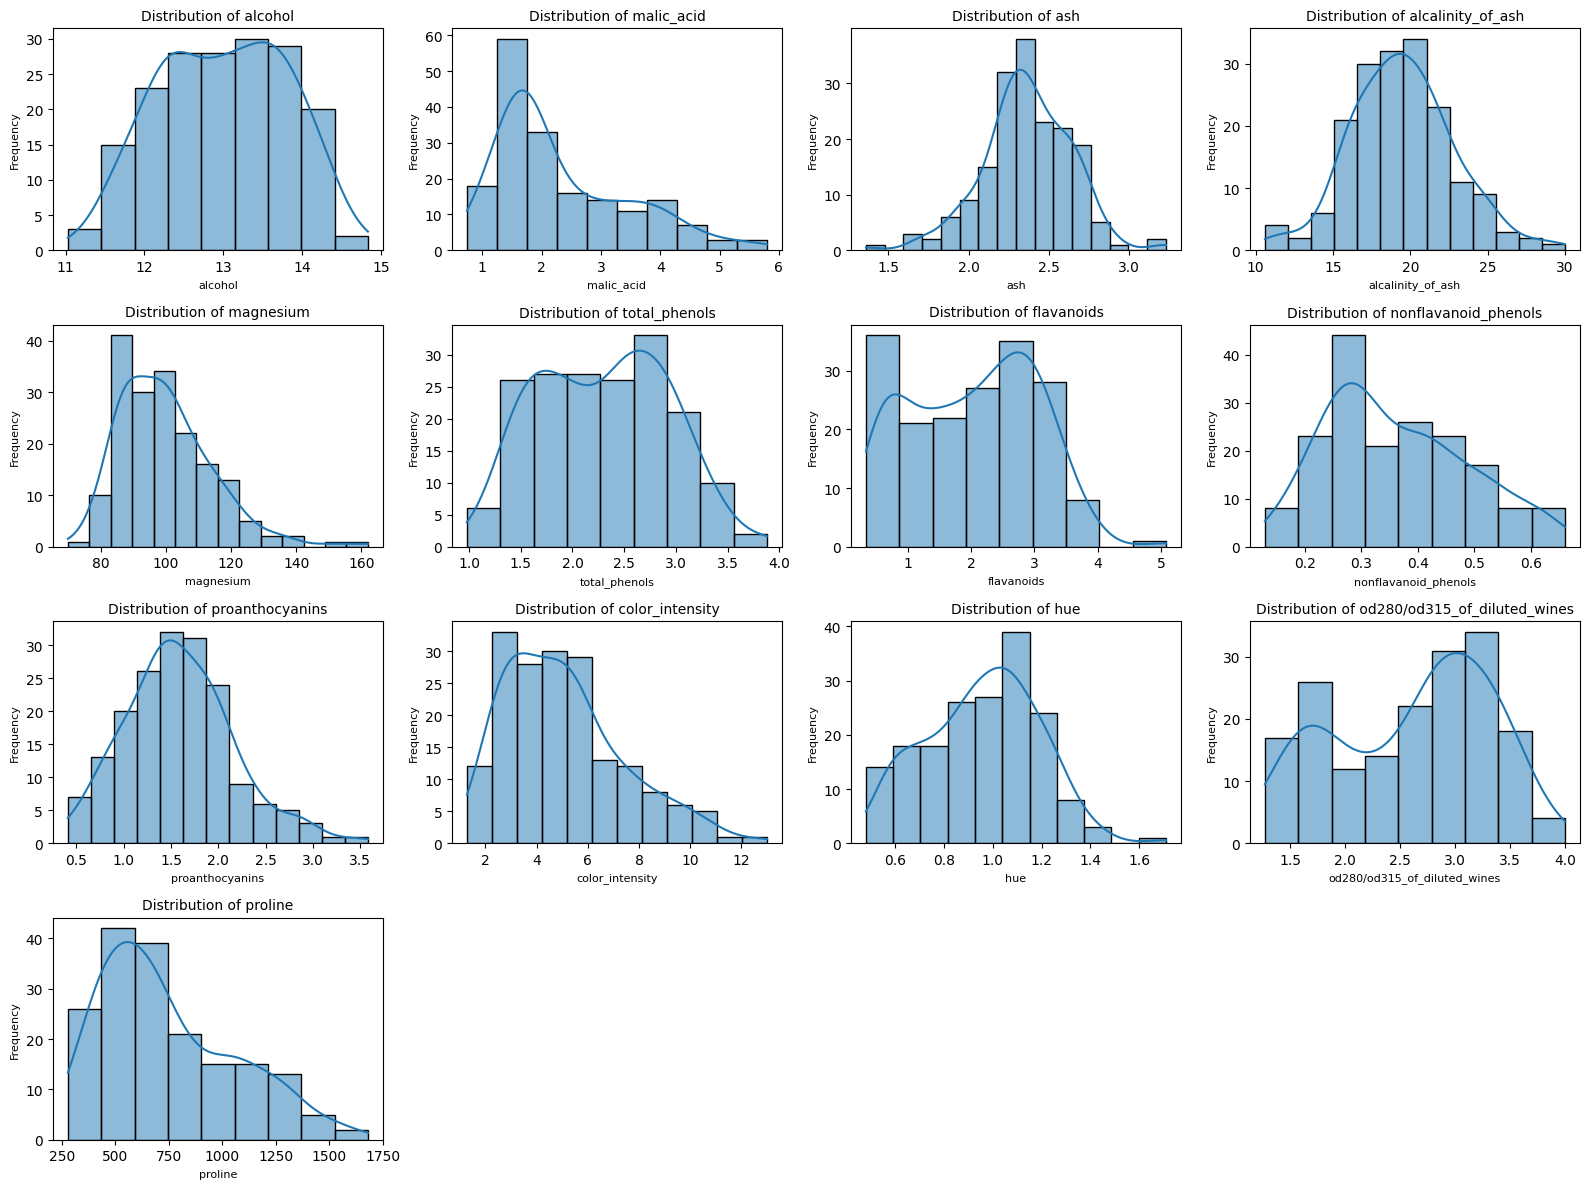

In [6]:
print("\n1.4. Visualizing Feature Distributions (Histograms):")
# This step is crucial for visually assessing the non-Gaussianity of the observed signals.
# ICA performs best when the underlying independent components are non-Gaussian.
# If the observed mixtures are clearly Gaussian, ICA might not be able to separate the sources effectively.
num_features = len(df.columns)
# Determine grid size for subplots
n_rows = (num_features + 3) // 4 # Roughly 4 columns per row
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3))
axes = axes.flatten() # Flatten the array of axes for easy iteration

for i, col in enumerate(df.columns):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}', fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# Interpretation: Observe the shapes of these histograms. Do they look like a bell curve (Gaussian)?
# Or are they skewed, bimodal, or flat (uniform)? Deviations from a perfect bell curve indicate
# non-Gaussianity, which is a good sign for ICA. Many features in the Wine dataset (e.g., 'malic_acid',
# 'ash', 'alcalinity_of_ash', 'proline') show clear signs of skewness or non-normal distributions,
# making this dataset well-suited for ICA.




1.5. Correlation Matrix (Linear Relationships):


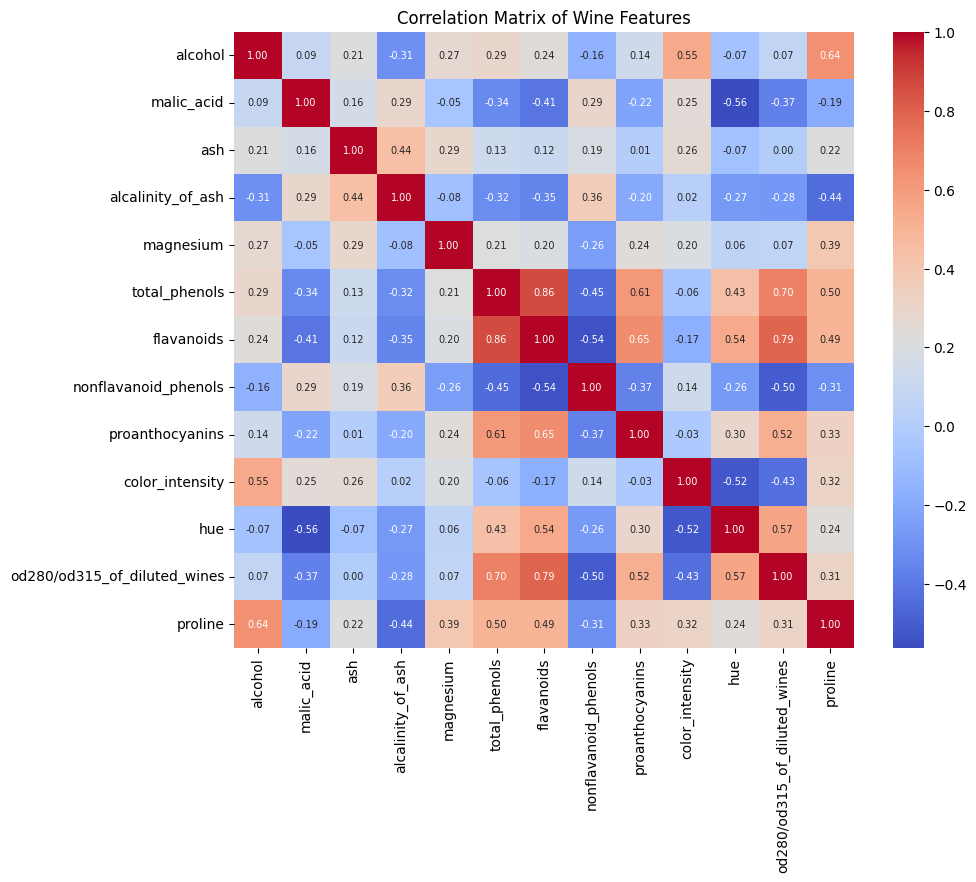

In [7]:
print("\n1.5. Correlation Matrix (Linear Relationships):")
# While ICA seeks statistical independence (a stronger condition than decorrelation),
# examining linear correlations can provide insights into how features are linearly related.
# High correlations suggest that features are not independent and are likely mixtures.
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8)) # Increased size for better readability with more features
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 7})
plt.title('Correlation Matrix of Wine Features')
plt.show()
# Interpretation: The correlation matrix shows the Pearson correlation coefficient between each pair of features.
# Values close to 1 or -1 indicate strong positive or negative linear correlation, respectively.
# Values close to 0 suggest a lack of strong linear correlation. We can observe many strong correlations here
# (e.g., 'flavanoids' and 'total_phenols' are highly correlated at 0.86; 'alcohol' and 'proline' at 0.64).
# These high correlations confirm that the observed features are not independent and are indeed
# "mixed" signals that ICA can attempt to separate into independent components.

In [8]:
print("\n2.1. Calculate Skewness for each feature:")
# Skewness measures the asymmetry of the probability distribution of a feature.
# A perfectly symmetrical distribution (like a normal distribution) has a skewness of 0.
# Positive skewness indicates a tail on the right (more values concentrated on the left).
# Negative skewness indicates a tail on the left (more values concentrated on the right).
# Significant deviation from 0 suggests non-Gaussianity.
feature_skewness = df.skew()
print(feature_skewness)
# Interpretation: Values significantly different from 0 (either positive or negative) indicate
# a non-symmetric distribution. For example, 'malic_acid' with a skewness of 1.09 is clearly
# positively skewed, while 'alcohol' with -0.05 is relatively symmetric. Features with high
# absolute skewness values are good candidates for ICA as they are likely non-Gaussian.




2.1. Calculate Skewness for each feature:
alcohol                        -0.051482
malic_acid                      1.039651
ash                            -0.176699
alcalinity_of_ash               0.213047
magnesium                       1.098191
total_phenols                   0.086639
flavanoids                      0.025344
nonflavanoid_phenols            0.450151
proanthocyanins                 0.517137
color_intensity                 0.868585
hue                             0.021091
od280/od315_of_diluted_wines   -0.307285
proline                         0.767822
dtype: float64


In [9]:
# --- Step 2: Check for Non-Gaussianity ---

print("\n--- Step 2: Check for Non-Gaussianity ---")
print("ICA requires underlying independent components to be non-Gaussian.")

print("\n2.1. Calculate Skewness for each feature:")
# Skewness: measures distribution asymmetry. 0 for normal.
# Values far from 0 indicate non-Gaussianity.
feature_skewness = df.skew()
print(feature_skewness)
# Interpretation: Non-zero values suggest non-symmetric, non-Gaussian distributions.

print("\n2.2. Calculate Kurtosis (Excess Kurtosis) for each feature:")
# Kurtosis: measures "tailedness" and peak sharpness. 0 for normal.
# Positive: heavy tails/sharper peak (more outliers). Negative: light tails/flatter peak.
feature_kurtosis = df.kurtosis()
print(feature_kurtosis)
# Interpretation: Values far from 0 indicate non-Gaussian "tailedness".

print("\n2.3. Statistical Tests for Normality (D'Agostino-Pearson Test):")
# H0: Data is normal. Reject H0 if p-value < 0.05.
# A rejected H0 means the feature is likely non-Gaussian.
print("{:<20} {:<10} {:<10} {:<10}".format("Feature", "Statistic", "P-value", "Non-Gaussian (p<0.05)?"))
print("-" * 60)
for col in df.columns:
    stat, p = normaltest(df[col])
    is_non_gaussian = "Yes" if p < 0.05 else "No"
    print(f"{col:<20} {stat:<10.2f} {p:<10.3f} {is_non_gaussian:<10}")

# Interpretation: Most features show p-values near 0, strongly rejecting normality.
# This confirms data suitability for ICA, as it relies on non-Gaussianity.


--- Step 2: Check for Non-Gaussianity ---
ICA requires underlying independent components to be non-Gaussian.

2.1. Calculate Skewness for each feature:
alcohol                        -0.051482
malic_acid                      1.039651
ash                            -0.176699
alcalinity_of_ash               0.213047
magnesium                       1.098191
total_phenols                   0.086639
flavanoids                      0.025344
nonflavanoid_phenols            0.450151
proanthocyanins                 0.517137
color_intensity                 0.868585
hue                             0.021091
od280/od315_of_diluted_wines   -0.307285
proline                         0.767822
dtype: float64

2.2. Calculate Kurtosis (Excess Kurtosis) for each feature:
alcohol                        -0.852500
malic_acid                      0.299207
ash                             1.143978
alcalinity_of_ash               0.487942
magnesium                       2.104991
total_phenols                  -0